wavenet paper: https://arxiv.org/pdf/1609.03499

In [7]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline 

In [3]:
words = open('names.txt').read().splitlines()
len(words)

32033

In [6]:
# set up the vocab size
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i,c in enumerate(chars)}
stoi['.'] = 0 # special token
itos = {i:c for c,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [45]:
block_size = 8 # context

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            idx = stoi[c]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx] # rm first char index
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.size(), Y.size())
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:n1])
X_val, y_val = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

torch.Size([182441, 8]) torch.Size([182441])
torch.Size([22902, 8]) torch.Size([22902])
torch.Size([22803, 8]) torch.Size([22803])


In [46]:
for x, y in zip(X_train[:20], y_train[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> e
.......e ---> l
......el ---> i
.....eli ---> a
....elia ---> n
...elian ---> y
..eliany ---> s
.elianys ---> .
........ ---> t
.......t ---> r
......tr ---> o
.....tro ---> y
....troy ---> .
........ ---> m
.......m ---> a
......ma ---> r
.....mar ---> k
....mark ---> u
...marku ---> s
..markus ---> .


In [68]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if x.ndim == 2:
      dim = 0
    elif x.ndim == 3:
      dim = (0,1)
    if self.training:
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
  
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C * self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    
    self.out = x
    return self.out
  
  def parameters(self):
    return []
  
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [17]:
torch.manual_seed(42)

In [69]:
n_embed = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [70]:
idx = torch.randint(0, X_train.shape[0], (4,))
Xb, Yb = X_train[idx], y_train[idx]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 26,  5,  4],
        [ 0,  0,  0,  0,  0,  0, 11,  1],
        [ 0,  0,  0,  0,  0,  5, 13, 13],
        [ 0,  0,  0,  0,  0,  0,  1,  4]])

In [71]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [73]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    idx = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, Yb = X_train[idx], y_train[idx]

    # forward
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward 
    for p in parameters:
        p.grad = None
    loss.backward()

    # update SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')    
    lossi.append(loss.log10().item())

      0/ 200000: 3.2910
  10000/ 200000: 1.9138
  20000/ 200000: 2.1656
  30000/ 200000: 1.8703
  40000/ 200000: 2.5589
  50000/ 200000: 1.8928
  60000/ 200000: 2.2477
  70000/ 200000: 2.0729
  80000/ 200000: 1.9292
  90000/ 200000: 2.2582
 100000/ 200000: 1.9197
 110000/ 200000: 1.9042
 120000/ 200000: 2.1604
 130000/ 200000: 2.4733
 140000/ 200000: 1.8346
 150000/ 200000: 2.2590
 160000/ 200000: 2.0791
 170000/ 200000: 1.8986
 180000/ 200000: 2.1920
 190000/ 200000: 2.0193


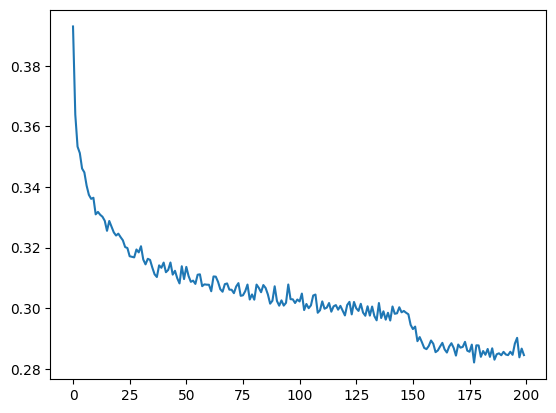

In [74]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [75]:
# put layers into eval mode
for layer in model.layers: 
    layer.training = False

In [76]:
# eval loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, y_train),
        'val': (X_val, y_val),
        'test': (X_test, y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.911821961402893
val 2.0130679607391357


In [77]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

adel.
decklani.
yanah.
reit.
madelinay.
ajlie.
mushaj.
haydin.
braina.
alenxis.
nafion.
drayven.
maiabi.
sajet.
nathalyn.
jeshi.
enzlynn.
aaylain.
shabret.
aymelia.
